In [1]:
# K-均值聚类支持函数
from numpy import *

def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return dataMat

# 计算向量欧式距离
def distEclud(vecA, vecB): 
    return sqrt(sum(power(vecA - vecB, 2)))

# 随机初始化K个质心
def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k,1) # 随机[0,1)上的数字
    return centroids

In [2]:
datMat = mat(loadDataSet('testSet.txt'))

In [3]:
min(datMat[:,0])

matrix([[-5.379713]])

In [4]:
min(datMat[:,1])

matrix([[-4.232586]])

In [5]:
max(datMat[:,0])

matrix([[4.838138]])

In [6]:
max(datMat[:,1])

matrix([[5.1904]])

In [7]:
randCent(datMat, 2)

matrix([[ 1.72921075, -3.64717795],
        [-3.15519472, -1.31721475]])

In [8]:
distEclud(datMat[0], datMat[1])

5.184632816681332

In [9]:
# K-均值聚类算法
def kMeans(dataSet, k, disMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = disMeas(centroids[j,:], dataSet[i, :])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex, minDist ** 2
        print(centroids)
        for cent in range(k):
            # 将数据集中所有属于当前质心类的样本通过条件过滤筛选出来
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A == cent)[0]]
            centroids[cent,:] = mean(ptsInClust, axis=0)
    return centroids, clusterAssment       

In [10]:
datMat = mat(loadDataSet('testSet.txt'))

In [11]:
myCentroids, clustAssing = kMeans(datMat, 4)

[[-4.13648355 -0.08557956]
 [ 3.54415002  1.13474832]
 [-4.24167902  1.33649106]
 [-3.90966433  2.7085927 ]]
[[-3.38237045 -2.9473363 ]
 [ 2.71473038  0.18858278]
 [-3.14546667  1.36566633]
 [-2.34085076  3.03826541]]
[[-3.01169468 -3.01238673]
 [ 2.87919639  0.14982103]
 [-3.14546667  1.36566633]
 [-1.90770758  3.21716042]]
[[-3.01169468 -3.01238673]
 [ 2.96765829 -0.04151062]
 [-3.55571825  1.8638865 ]
 [-1.43546415  3.22862095]]
[[-3.01169468 -3.01238673]
 [ 2.99405094 -0.1605263 ]
 [-3.3856885   2.52409988]
 [-0.80882041  3.27771606]]
[[-3.01169468 -3.01238673]
 [ 3.07345093 -0.81752607]
 [-3.08283992  2.632221  ]
 [ 0.49475994  3.44003789]]
[[-3.19984738 -2.96423548]
 [ 2.96839327 -2.13784255]
 [-2.64677572  2.78993217]
 [ 2.17079205  3.33719989]]
[[-3.38237045 -2.9473363 ]
 [ 2.80293085 -2.7315146 ]
 [-2.46154315  2.78737555]
 [ 2.6265299   3.10868015]]


In [12]:
# 为了避免陷入局部最小点，下面提出二分K-均值聚类算法
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList = [centroid0]
    
    for j in range(m):
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:]) ** 2
    while (len(centList) < k): # 选取误差和最大的簇进行划分，直到簇数达到k
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A == i)[0],:]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A != i)[0],1])
            print("sseSplit, and notSplit: %f %f" % (sseSplit, sseNotSplit))
            
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0], 0] = len(centList) # 索引从0开始，意味着簇二分下来属于1的簇的索引归到最后
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0], 0] = bestCentToSplit
        print("the bestCentToSplit is: %f" % bestCentToSplit)
        print("the len of bestClustAss is: %d" % len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:] = bestClustAss  
    return mat(centList), clusterAssment

In [13]:
datMat3 = mat(loadDataSet('testSet2.txt'))

In [14]:
centList, myNewAssments = biKmeans(datMat3, 3)

[[ 2.39834847  1.25801456]
 [-3.60078993  0.08157101]]
[[ 2.29222778  1.72074989]
 [-2.16222773  0.81998667]]
[[ 2.93386365  3.12782785]
 [-1.70351595  0.27408125]]
sseSplit, and notSplit: 541.297629 0.000000
the bestCentToSplit is: 0.000000
the len of bestClustAss is: 60
[[3.62110529 1.21408922]
 [4.38564275 1.04261493]]
[[2.84580389 3.10769711]
 [4.606999   3.510312  ]]
[[2.48449707 2.95091147]
 [4.2819634  3.658577  ]]
sseSplit, and notSplit: 25.535515 501.768331
[[ 0.08085843 -1.81882786]
 [-1.88037554 -0.65108325]]
[[-0.18508106 -3.04706075]
 [-2.71580587  2.48817592]]
[[-0.45965615 -2.7782156 ]
 [-2.94737575  3.3263781 ]]
sseSplit, and notSplit: 67.220200 39.529299
the bestCentToSplit is: 1.000000
the len of bestClustAss is: 40


In [15]:
centList

matrix([[ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ],
        [-2.94737575,  3.3263781 ]])

示例：对地图上的点进行聚类

获取数据：由于网站进不去，所以直接取得数据，文件名为places.txt

In [16]:
# 球面距离计算及簇绘图函数
# 设所求点A:纬度β1，经度α1；点B：纬度β2，经度α2。dist=R·arc cos[cosβ1cosβ2cos（α1-α2）+sinβ1sinβ2] 
def distSLC(vecA, vecB):
    a = sin(vecA[0,1] * pi / 180) * sin(vecB[0,1] * pi / 180)
    b = cos(vecA[0,1] * pi / 180) * cos(vecB[0,1] * pi / 180) * \
                        cos(pi * (vecB[0,0] - vecA[0,0]) / 180)
    return arccos(a + b) * 6371.0

import matplotlib
import matplotlib.pyplot as plt
def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    
    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0 = fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP) 
    ax1 = fig.add_axes(rect, label='ax1', frameon=False) # frameon:If False, suppress drawing the figure frame
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)] # 这里去掉取余运算，结果一样
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0],
                    ptsInCurrCluster[:,1].flatten().A[0],
                   marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0],
               myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

[[-122.45784093   45.62446396]
 [-122.72152578   45.54267173]]
[[-122.50578862   45.50830608]
 [-122.66090011   45.51323541]]
[[-122.53114732   45.51335191]
 [-122.67873228   45.51181745]]
[[-122.54432282   45.52042118]
 [-122.69133217   45.5067651 ]]
[[-122.54868607   45.51882187]
 [-122.69551477   45.50729503]]
sseSplit, and notSplit: 3043.263316 0.000000
the bestCentToSplit is: 0.000000
the len of bestClustAss is: 69
[[-122.53933603   45.53716514]
 [-122.43116656   45.53179358]]
[[-122.56208315   45.52250274]
 [-122.42811233   45.485694  ]]
sseSplit, and notSplit: 511.806538 2191.824428
[[-122.83921681   45.5214169 ]
 [-122.71736792   45.39984928]]
[[-122.71606864   45.53761   ]
 [-122.66891565   45.46806388]]
[[-122.70994758   45.53654463]
 [-122.67242227   45.46049567]]
[[-122.70777076   45.53557164]
 [-122.67362907   45.45680107]]
sseSplit, and notSplit: 1439.768163 851.438889
the bestCentToSplit is: 1.000000
the len of bestClustAss is: 39
[[-122.48350172   45.52082709]
 [-122.41

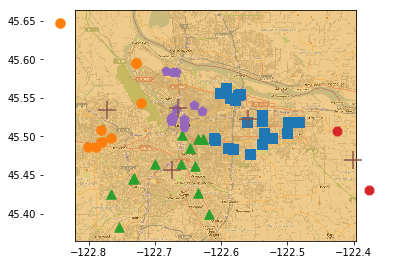

In [17]:
clusterClubs(5)

[[-122.42013972   45.42832347]
 [-122.81043663   45.46774636]]
[[-122.53919388   45.50907692]
 [-122.68422298   45.5141418 ]]
[[-122.55095081   45.5149589 ]
 [-122.69753113   45.51014305]]
[[-122.54868607   45.51882187]
 [-122.69551477   45.50729503]]
sseSplit, and notSplit: 3043.263316 0.000000
the bestCentToSplit is: 0.000000
the len of bestClustAss is: 69
[[-122.53025432   45.44809011]
 [-122.59157232   45.46005862]]
[[-122.4927627    45.4967901 ]
 [-122.57664775   45.52983775]]
[[-122.49860291   45.49496564]
 [-122.57768158   45.53263337]]
sseSplit, and notSplit: 464.720598 2191.824428
[[-122.76126309   45.61241804]
 [-122.78435995   45.51746716]]
[[-122.72070683   45.59796783]
 [-122.69093439   45.49080906]]
[[-122.72072414   45.59011757]
 [-122.69000022   45.48917759]]
sseSplit, and notSplit: 1435.437849 851.438889
the bestCentToSplit is: 1.000000
the len of bestClustAss is: 39
[[-122.57753751   45.51367059]
 [-122.50678243   45.54850753]]
[[-122.56828388   45.52317171]
 [-122.47

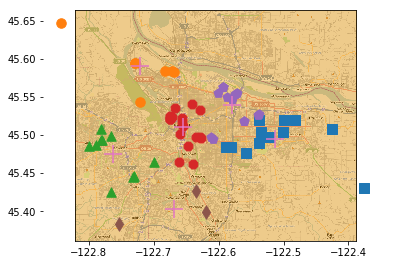

In [19]:
clusterClubs(6)